In [18]:
#importing libraries

import os
import numpy as np
import torch
import time
import torch.utils.data
from torch.utils.data.dataset import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import cv2
import glob
from PIL import Image
import ntpath
import os
from tqdm import tqdm
from tqdm import trange
%matplotlib inline

In [1]:
def START_seed():
    seed = 9
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

lr = 0.01 
epochs=20
device = 'cuda'
train_batch_size = 128
test_batch_size = 128

In [2]:
from dataset import ImageWoof
from matplotlib import pyplot as plt

from torchinfo import summary

batch_size = 64

transform = transforms.Compose(
        [transforms.ToTensor(), 
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
         transforms.Resize((160, 160), antialias=True)
        ]
    )

trainset = ImageWoof(
    root=".", train=True, transform=transform, img_size=160
)
testset = ImageWoof(
    root=".", train=False, transform=transform, img_size=160
)

## split into train, val, test 
print(len(trainset))     
val_size = int(0.1 * len(trainset))
print(val_size)
train_size = len(trainset) - val_size
train, val = torch.utils.data.random_split(trainset, [train_size, val_size])    

train_loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, num_workers=1
)
val_loader = torch.utils.data.DataLoader(
    val, batch_size=batch_size, shuffle=False, num_workers=1
)    
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=1
)

print("Trainset size: ", len(train)//batch_size)
print("Valset size: ", len(val)//batch_size)
print("Testset size: ", len(testset)//batch_size)


NameError: name 'transforms' is not defined

## Visualizing Data

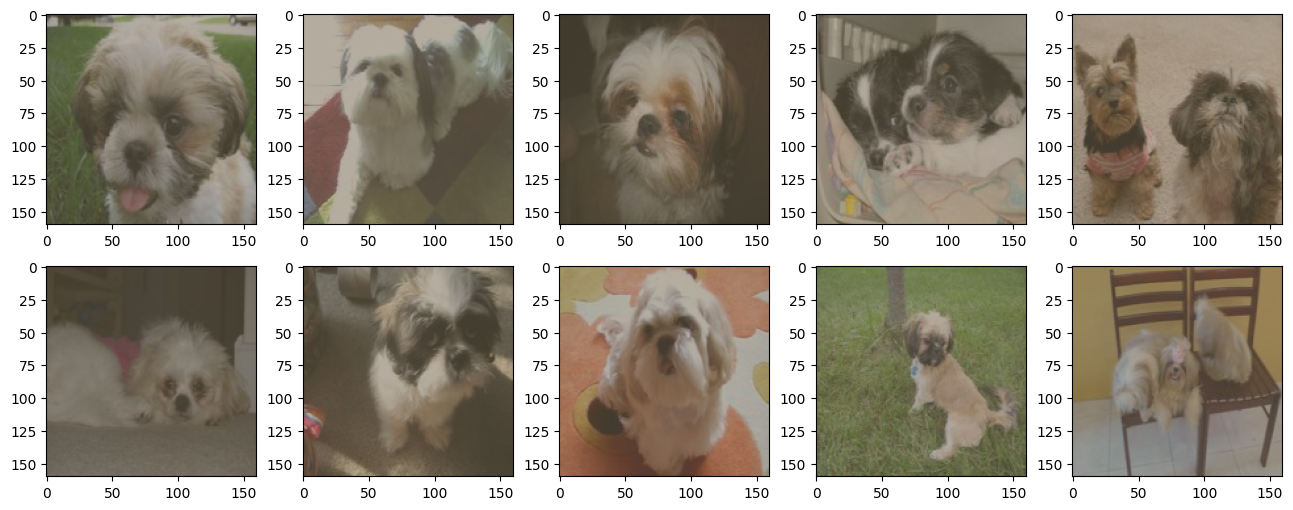

In [21]:
# show some images
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = test_loader.dataset.__getitem__(i)
    image= image.permute(1,2,0).numpy()
    image = (image*std)+mean
    plt.imshow(image)

### Training and evaluation loop

In [24]:
## Creating training loop
def train(model):
    model.train()
    train_loss = 0
    total = 0
    correct=0
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            # send to device
            data, target = data.to(device), target.to(device)
    
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*data.size(0)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            tepoch.set_postfix(loss=train_loss/(batch_idx+1), lr=optimizer.param_groups[0]['lr'])
        print(' train loss: {:.4f} accuracy: {:.4f}'.format(train_loss/(batch_idx+1), 100.*correct/total))

In [25]:
best_accuracy = 0.0
def validate(model):
    global best_accuracy
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    with tqdm(val_loader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            data, target = data.to(device), target.to(device)
    
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
        if (100.*correct/total) > best_accuracy:
            print("Saving the best model...")
            best_accuracy = (100.*correct/total)
            torch.save(model.state_dict(), 'best_model.pth')
        print(' val loss: {:.4f} accuracy: {:.4f} best_accuracy: {:.4f}'.format(test_loss/(batch_idx+1), 100.*correct/total, best_accuracy))


### Initialise the model, optimizers, schedulers 

In [26]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 8, 7, 1),
            nn.ReLU(),
            nn.Conv2d(8, 8, 7, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            #####
            nn.Conv2d(8, 16, 5, 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            #####
            nn.Conv2d(16, 32, 3, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(
                output_size=8,
            ),
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        #print("feature", features)
        features = torch.flatten(features, 1)
        #print("flatten", features)
        out = self.classifier(features)
        #print(out)
        return out

    def num_of_params(self):
        total = 0
        for layer_params in self.feature_extractor.parameters():
            total += layer_params.numel()
        for layer_params in self.classifier.parameters():
            total += layer_params.numel()
        return total


In [27]:
START_seed()
import torchvision.models as models

# model = models.vgg16(pretrained=False)
# model.classifier[-1].out_features = 6
# model.head = nn.Linear(model.head.in_features, 6)

# model = models.resnet18(pretrained=False)
# # model.classifier[-1].out_features = 6
# model.fc = nn.Linear(model.fc.in_features, 10)

model = CNN(num_classes=10)

print(model)

pytorch_total_params = sum(p.numel() for p in  model.parameters())
print('Number of parameters: {0}'.format(pytorch_total_params))

CNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): AdaptiveAvgPool2d(output_size=8)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [35]:
model.to(device)
start = time.time()

for epoch in range(0, epochs):
    print("epoch number: {0}".format(epoch))
    train( model)
    validate(model)
end = time.time()
Total_time=end-start
print('Total training and inference time is: {0}'.format(Total_time))

epoch number: 0


100%|██████████| 127/127 [00:13<00:00,  9.50batch/s, loss=134, lr=0.001]


 train loss: 133.8114 accuracy: 21.7900


100%|██████████| 15/15 [00:01<00:00,  9.79batch/s]


 val loss: 2.0486 accuracy: 24.9446 best_accuracy: 27.7162
epoch number: 1


100%|██████████| 127/127 [00:13<00:00,  9.65batch/s, loss=128, lr=0.001]


 train loss: 128.4570 accuracy: 26.0864


100%|██████████| 15/15 [00:01<00:00,  9.67batch/s]


 val loss: 2.0072 accuracy: 26.0532 best_accuracy: 27.7162
epoch number: 2


100%|██████████| 127/127 [00:13<00:00,  9.54batch/s, loss=124, lr=0.001]


 train loss: 124.0313 accuracy: 29.5088


100%|██████████| 15/15 [00:01<00:00,  9.85batch/s]


Saving the best model...
 val loss: 1.9842 accuracy: 28.1596 best_accuracy: 28.1596
epoch number: 3


100%|██████████| 127/127 [00:12<00:00, 10.20batch/s, loss=121, lr=0.001]


 train loss: 120.8023 accuracy: 30.8507


100%|██████████| 15/15 [00:01<00:00, 10.01batch/s]


 val loss: 1.9365 accuracy: 28.1596 best_accuracy: 28.1596
epoch number: 4


100%|██████████| 127/127 [00:12<00:00, 10.08batch/s, loss=115, lr=0.001]


 train loss: 115.4072 accuracy: 33.5960


100%|██████████| 15/15 [00:01<00:00, 10.41batch/s]


 val loss: 1.9388 accuracy: 28.1596 best_accuracy: 28.1596
epoch number: 5


100%|██████████| 127/127 [00:12<00:00,  9.89batch/s, loss=110, lr=0.001]


 train loss: 110.4466 accuracy: 37.2769


100%|██████████| 15/15 [00:01<00:00, 10.18batch/s]


Saving the best model...
 val loss: 1.9432 accuracy: 30.8204 best_accuracy: 30.8204
epoch number: 6


100%|██████████| 127/127 [00:12<00:00,  9.99batch/s, loss=104, lr=0.001]


 train loss: 103.8985 accuracy: 41.8195


100%|██████████| 15/15 [00:01<00:00, 10.49batch/s]


 val loss: 1.9724 accuracy: 29.3792 best_accuracy: 30.8204
epoch number: 7


100%|██████████| 127/127 [00:12<00:00,  9.79batch/s, loss=94.9, lr=0.001]


 train loss: 94.9016 accuracy: 47.1254


100%|██████████| 15/15 [00:01<00:00,  9.78batch/s]


Saving the best model...
 val loss: 2.0294 accuracy: 32.5942 best_accuracy: 32.5942
epoch number: 8


100%|██████████| 127/127 [00:12<00:00,  9.78batch/s, loss=81.8, lr=0.001]


 train loss: 81.8091 accuracy: 54.7089


100%|██████████| 15/15 [00:01<00:00, 10.01batch/s]


 val loss: 2.1183 accuracy: 32.4834 best_accuracy: 32.5942
epoch number: 9


100%|██████████| 127/127 [00:12<00:00, 10.25batch/s, loss=66, lr=0.001]  


 train loss: 66.0095 accuracy: 63.2771


100%|██████████| 15/15 [00:01<00:00, 10.18batch/s]


Saving the best model...
 val loss: 2.4315 accuracy: 33.8137 best_accuracy: 33.8137
epoch number: 10


100%|██████████| 127/127 [00:12<00:00, 10.11batch/s, loss=50.6, lr=0.001]


 train loss: 50.5966 accuracy: 72.1901


100%|██████████| 15/15 [00:01<00:00,  9.75batch/s]


 val loss: 2.7339 accuracy: 31.7073 best_accuracy: 33.8137
epoch number: 11


100%|██████████| 127/127 [00:12<00:00,  9.80batch/s, loss=36.7, lr=0.001]


 train loss: 36.7466 accuracy: 80.1305


100%|██████████| 15/15 [00:01<00:00, 10.33batch/s]


 val loss: 3.4598 accuracy: 28.7140 best_accuracy: 33.8137
epoch number: 12


100%|██████████| 127/127 [00:12<00:00,  9.91batch/s, loss=23.8, lr=0.001]


 train loss: 23.8237 accuracy: 87.5415


100%|██████████| 15/15 [00:01<00:00, 10.28batch/s]


 val loss: 3.9819 accuracy: 31.1530 best_accuracy: 33.8137
epoch number: 13


100%|██████████| 127/127 [00:12<00:00, 10.01batch/s, loss=21.1, lr=0.001]


 train loss: 21.1348 accuracy: 89.0311


100%|██████████| 15/15 [00:01<00:00,  9.93batch/s]


 val loss: 4.7148 accuracy: 32.1508 best_accuracy: 33.8137
epoch number: 14


100%|██████████| 127/127 [00:13<00:00,  9.37batch/s, loss=16.3, lr=0.001]


 train loss: 16.3465 accuracy: 91.7395


100%|██████████| 15/15 [00:01<00:00,  9.78batch/s]


 val loss: 4.2929 accuracy: 30.1552 best_accuracy: 33.8137
epoch number: 15


100%|██████████| 127/127 [00:12<00:00,  9.81batch/s, loss=9.36, lr=0.001]


 train loss: 9.3625 accuracy: 95.3958


100%|██████████| 15/15 [00:01<00:00, 10.00batch/s]


 val loss: 5.0689 accuracy: 30.4878 best_accuracy: 33.8137
epoch number: 16


100%|██████████| 127/127 [00:12<00:00,  9.99batch/s, loss=10.3, lr=0.001]


 train loss: 10.2990 accuracy: 94.9772


100%|██████████| 15/15 [00:01<00:00,  9.99batch/s]


 val loss: 4.9628 accuracy: 30.7095 best_accuracy: 33.8137
epoch number: 17


100%|██████████| 127/127 [00:12<00:00,  9.94batch/s, loss=7.81, lr=0.001]


 train loss: 7.8125 accuracy: 96.1837


100%|██████████| 15/15 [00:01<00:00,  9.63batch/s]


 val loss: 5.4051 accuracy: 31.2639 best_accuracy: 33.8137
epoch number: 18


100%|██████████| 127/127 [00:12<00:00,  9.90batch/s, loss=7.21, lr=0.001]


 train loss: 7.2066 accuracy: 96.2945


100%|██████████| 15/15 [00:01<00:00,  9.35batch/s]


 val loss: 6.1583 accuracy: 31.1530 best_accuracy: 33.8137
epoch number: 19


100%|██████████| 127/127 [00:12<00:00, 10.05batch/s, loss=6.86, lr=0.001]


 train loss: 6.8650 accuracy: 96.5530


100%|██████████| 15/15 [00:01<00:00,  9.59batch/s]

 val loss: 5.7575 accuracy: 28.9357 best_accuracy: 33.8137
Total training and inference time is: 287.71499133110046


### Test the model 

In [ ]:
def test_best_model(model, test_loader, criterion, best_model_path):
    # Load the best model
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    with tqdm(test_loader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()

            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        accuracy = 100. * correct / total
        print('Test loss: {:.4f} Accuracy: {:.2f}%'.format(test_loss/(batch_idx+1), accuracy))

# Usage example:

# Assuming you have a model, test_loader, and best_model_path defined

best_model_path = 'best_model.pth'  # Replace with the actual path and filename of the best model

test_best_model(model, test_loader, nn.CrossEntropyLoss(), best_model_path)


100%|██████████| 62/62 [00:26<00:00,  2.36batch/s]

Test loss: 2.3093 Accuracy: 41.31%
